In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np


from andbro__fft import __fft
from scipy.signal import hilbert, welch
from obspy.clients.fdsn import RoutingClient
from scipy import stats

from obspy import UTCDateTime

In [2]:
path = "/home/andbro/Documents/ROMY/monobeams/monobeam_data/"
path2plots = "/home/andbro/Documents/ROMY/monobeams/West_Ring/"


route = RoutingClient("eida-routing")

In [3]:

def __get_data(path, tbeg, tend, loc=None):
    
    
    if loc == "local":
        try:
            f1 = obspy.read(path+f'DROMY_F1V_{date}.mseed')

            f2 = obspy.read(path+f'DROMY_F2V_{date}.mseed')

            bjv = obspy.read(path+f'ROMY_BJV_{date}.mseed')

            fjv = obspy.read(path+f'DROMY_FJV_{date}.mseed')
        except:
            print("loading data from george failed!")

    elif loc == "george":
        
        from obspy import UTCDateTime
        from obspy.clients.fdsn import Client

        waveform_client = Client(base_url='http://george', timeout=200)
        try:
            f1  = waveform_client.get_waveforms(location='', channel='F1V', network='BW', station='DROMY', starttime=tbeg, endtime=tend)
            f2  = waveform_client.get_waveforms(location='', channel='F2V', network='BW', station='DROMY', starttime=tbeg, endtime=tend)
            bjv = waveform_client.get_waveforms(location='', channel='BJV', network='BW', station='ROMY', starttime=tbeg, endtime=tend)
            fjv = waveform_client.get_waveforms(location='', channel='FJV', network='BW', station='DROMY', starttime=tbeg, endtime=tend)
        except:
            print("loading data locally failed!")
            
        
    f1_inv = route.get_stations(network="BW", station="ROMY", level="response")
    f2_inv = route.get_stations(network="BW", station="ROMY", level="response")
    bjv_inv = route.get_stations(network="BW", station="ROMY", level="response")
    fjv_inv = route.get_stations(network="BW", station="ROMY", level="response")

    tbeg = f1[0].stats.starttime

    return bjv, fjv, f1, f2


In [ ]:
## connected monobeams directly to Obsidian
# tbeg = UTCDateTime("2021-03-04 17:00")
# tend = UTCDateTime("2021-03-04 18:30")

tbeg = UTCDateTime("2021-03-09 21:00")
tend = UTCDateTime("2021-03-09 21:10")

## reset west ring with monobeam measurement
tbeg = UTCDateTime("2022-03-31 19:00")
tend = UTCDateTime("2022-03-31 19:30")

## after closing open ends RN & RE
tbeg = UTCDateTime("2022-04-05 05:00")
tend = UTCDateTime("2022-04-05 05:20")

### Load Data

In [4]:
bjv0, fjv0, f10, f20 = __get_data(path, tbeg, tend, loc="george")

### Convert and Plot Data

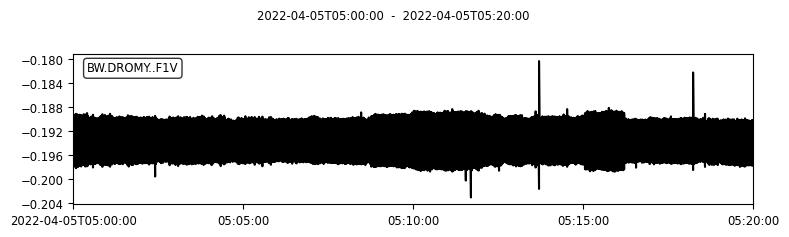

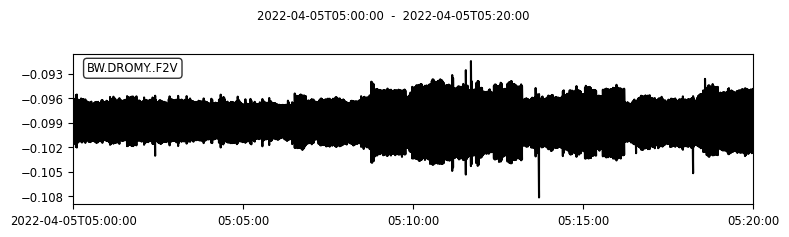

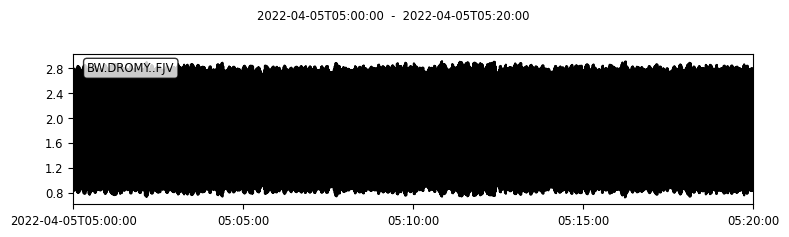

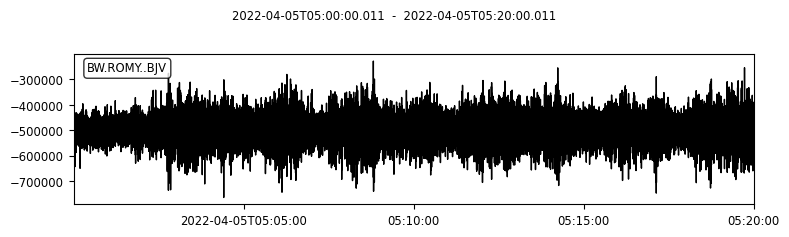

In [5]:
bjv, fjv, f1, f2 = bjv0.copy(), fjv0.copy(), f10.copy(), f20.copy()

counts_to_volts = 0.59604645e-6 # V / count

fjv[0].data = fjv[0].data * counts_to_volts
f1[0].data = f1[0].data * counts_to_volts
f2[0].data = f2[0].data * counts_to_volts


f1.plot();
f2.plot();
fjv.plot();
bjv.plot();

### Compare Time Series and Spectra

In [7]:
def __makeplot(st1, st2, st3, st4, sample_offset, Nsamples, freq1=None, freq2=None, env=False):

    bjv = st1; fjv = st2; f1 = st3; f2= st4
    

    def __get_timeline(tr, s1, s2):
        dt = tr.stats.delta
        return np.arange(0, tr.data.size*dt, dt)


    num0 = sample_offset
    ds   = Nsamples

#     st1 = st1.trim(starttime=st1[0].stats.starttime, endtime=st1[0].stats.starttime+ds/5000)
#     st2 = st2.trim(starttime=st2[0].stats.starttime, endtime=st2[0].stats.starttime+ds/5000)
#     st3 = st3.trim(starttime=st3[0].stats.starttime, endtime=st3[0].stats.starttime+ds/5000)
#     st4 = st4.trim(starttime=st4[0].stats.starttime, endtime=st4[0].stats.starttime+ds/5000)


    f1_t = __get_timeline(f1[0], num0, num0+ds)
    f2_t = __get_timeline(f2[0], num0, num0+ds)
    fjv_t = __get_timeline(fjv[0], num0, num0+ds)    
    bjv_t = __get_timeline(bjv[0], num0, num0+ds)

    
    f1_ff, f1_welch  = welch(f1[0].data, f1[0].stats.sampling_rate, nperseg=1e6)
    f2_ff, f2_welch = welch(f2[0].data, f2[0].stats.sampling_rate, nperseg=1e6)
    fjv_ff, fjv_welch = welch(fjv[0].data, fjv[0].stats.sampling_rate, nperseg=1e6)

    
    f1_env = np.abs(hilbert(f1[0].data))
    f2_env = np.abs(hilbert(f2[0].data))


    bjv_ads, bjv_f, phase = __fft(bjv[0].data, bjv[0].stats.delta) 
#     f1_ads, f1_f = __fft(f1[0].data, f1[0].stats.delta)
#     f2_ads, f2_f = __fft(f2[0].data, f2[0].stats.delta)
#     fjv_ads, fjv_f = __fft(fjv[0].data, fjv[0].stats.delta)
    
    
    ## __________________________________________________________--
    
    fig, ax = plt.subplots(4, 2, figsize=(15,13))
    
    font = 13

    ax[0,0].plot(bjv_t[num0:num0+ds], bjv[0].data[num0:num0+ds], label="BJV")
    ax[0,1].plot(bjv_f, bjv_ads)
#     ax[0,1].set_yscale("log")

    
    ax[1,0].plot(fjv_t[num0:num0+ds], fjv[0].data[num0:num0+ds], label="BJV raw")
    ax[1,1].plot(fjv_ff, fjv_welch)
#     ax[1,1].plot(fjv_f, fjv_ads)
    ax[1,1].set_yscale("log")


    ax[2,0].plot(f1_t[num0:num0+ds], f1[0].data[num0:num0+ds], label="F1")    
#     ax[2,1].plot(f1_f, f1_ads)
    ax[2,1].plot(f1_ff, f1_welch)
    ax[2,1].set_yscale("log")

    

    ax[3,0].plot(f2_t[num0:num0+ds], f2[0].data[num0:num0+ds], label="F2")
#     ax[3,1].plot(f2_f, f2_ads)
    ax[3,1].plot(f2_ff, f2_welch)
    ax[3,1].set_yscale("log")

    if env == True:
        ax[2,0].plot(f1_t[num0:num0+ds], f1_env[num0:num0+ds], color="darkorange")    
#         ax[2,0].plot(f1_t[num0:num0+ds], -f1_env[num0:num0+ds], color="darkorange")    

        ax[3,0].plot(f2_t[num0:num0+ds], f2_env[num0:num0+ds], color="darkorange")    
#         ax[3,0].plot(f2_t[num0:num0+ds], -f2_env[num0:num0+ds], color="darkorange")    
        
    if freq1 is not None:

        
#         ax[0,1].set_xlim(freq1, freq2)
        ax[1,1].set_xlim(freq1, freq2)
        ax[2,1].set_xlim(freq1, freq2)
        ax[3,1].set_xlim(freq1, freq2)


        freq1_ind = list(f1_ff).index(freq1)
        freq2_ind = list(f1_ff).index(freq2)

        ax[1,1].set_ylim(np.min(fjv_welch[freq1_ind:freq2_ind]), np.max(fjv_welch[freq1_ind:freq2_ind]))
        ax[2,1].set_ylim(np.min(f1_welch[freq1_ind:freq2_ind]), np.max(f1_welch[freq1_ind:freq2_ind]))
        ax[3,1].set_ylim(np.min(f2_welch[freq1_ind:freq2_ind]), np.max(f2_welch[freq1_ind:freq2_ind]))

    for i in [1, 2, 3]:
        for fnet in range(50,1050,50):
            ax[i,1].axvline(fnet, color="red", ls="--", zorder=-1, alpha=0.5)
        
        ax[i,1].axvline(16+2/3, color="green", ls="--", zorder=-1, alpha=0.5)
    
    
    ax[3,0].set_xlabel('Time (s)', fontsize=13)  
    ax[3,1].set_xlabel('Frequency (Hz)', fontsize=13)  
        
    ax[0,0].set_ylabel('rotation rate (rad/s)', fontsize=13)  
    ax[1,0].set_ylabel('amplitude (V)', fontsize=13)  
    ax[2,0].set_ylabel('amplitude (V)', fontsize=13)  
    ax[3,0].set_ylabel('amplitude (V)', fontsize=13)  

    ax[0,1].set_ylabel(r'psd $(rad^2/(s^2 Hz)$', fontsize=13)  
    ax[1,1].set_ylabel(r'psd ($V^2 / Hz$)', fontsize=13)  
    ax[2,1].set_ylabel(r'psd ($V^2 / Hz$)', fontsize=13)  
    ax[3,1].set_ylabel(r'psd ($V^2 / Hz$)', fontsize=13)  
             
    ax[0,0].legend(loc="lower right") 
    ax[1,0].legend(loc="lower right")
    ax[2,0].legend(loc="lower right")
    ax[3,0].legend(loc="lower right")
    
    fig.suptitle(f"West Ring on {st1[0].stats.starttime.date}", x=0.5, y=0.93, fontsize=font+2)
    
    plt.show();   
    
    return fig 

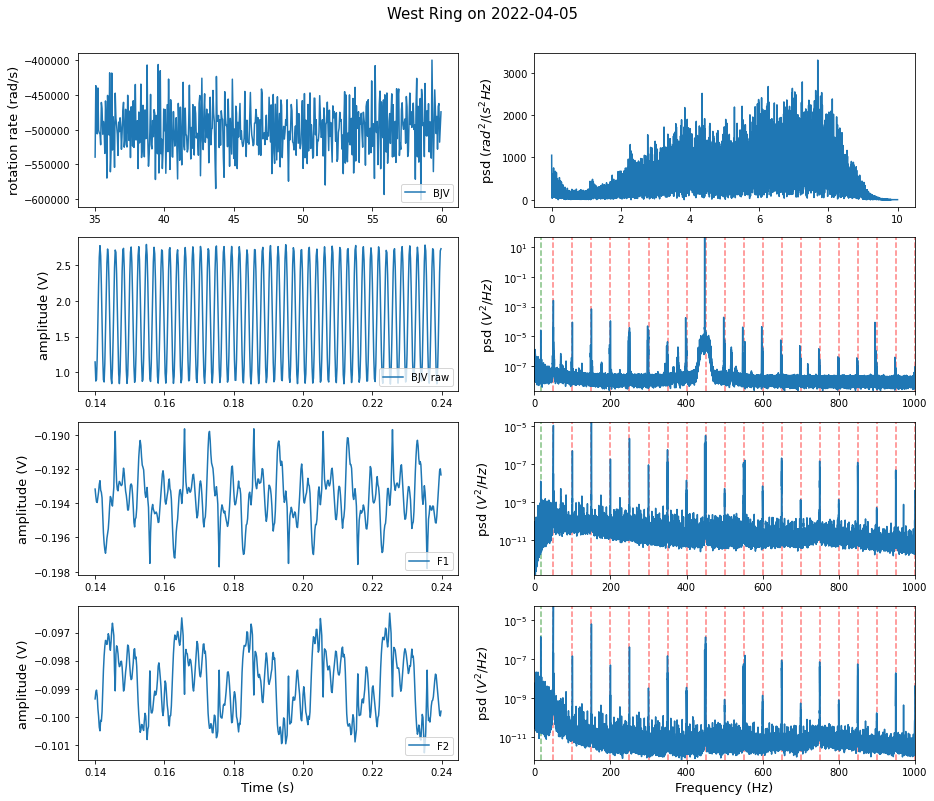

In [8]:
Nsamples = 500
sample_offset = 700

__makeplot(bjv, fjv, f1, f2, sample_offset, Nsamples, freq1=0, freq2=1000);

## Statistics

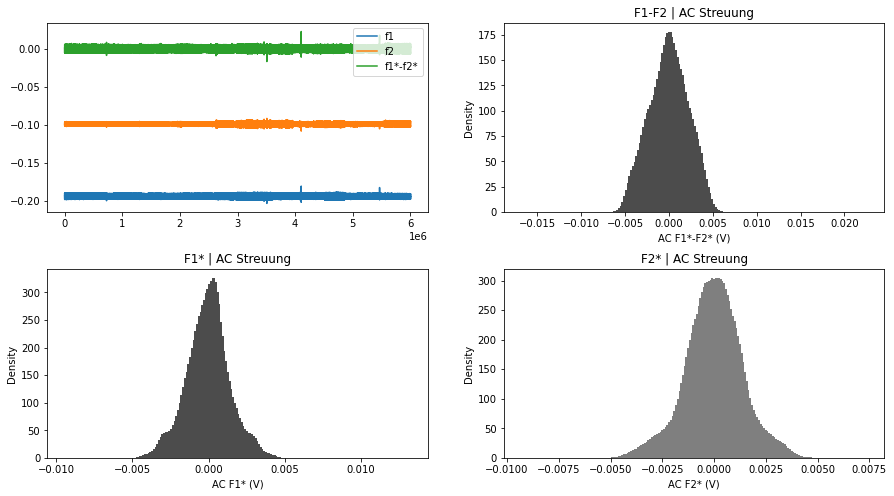

In [9]:
from numpy import median

def __plot_histogramms():

    # f1_new = abs(f1[0].data/max(abs(f1[0].data)))
    # f2_new = abs(f2[0].data/max(abs(f2[0].data)))

    f1_new = f1[0].data - median(f1[0].data)
    f2_new = f2[0].data - median(f2[0].data)


    data = f1_new - f2_new


    plt.figure(figsize=(15,8))
    plt.subplots_adjust(hspace=0.3)

    ## _______________________
    plt.subplot(2,2,1)

    plt.plot(f1[0].data, label="f1")
    plt.plot(f2[0].data, label="f2")

    plt.plot(data, label="f1*-f2*")

    plt.legend(loc="upper right")


    ## _______________________
    plt.subplot(2,2,2)
    plt.hist(data,
             bins=200,
    #          range=(0,1),
             rwidth=1.0,
             density=True,
             color="black",
             alpha=0.5,
             label="test",
            );

    plt.title("F1-F2 | AC Streuung")
    plt.xlabel("AC F1*-F2* (V)")
    plt.ylabel("Density")

    ## _______________________
    plt.subplot(2,2,3)
    plt.hist(f1_new,
             bins=200,
             rwidth=1.0,
             density=True,
             color="black",
             alpha=0.5,
            );

    plt.title("F1* | AC Streuung")
    plt.xlabel("AC F1* (V)")
    plt.ylabel("Density")

    ## _______________________
    plt.subplot(2,2,4)
    plt.hist(f2_new,
             bins=200,
             rwidth=1.0,
             density=True,
             color="black",
             alpha=0.5,
            );

    plt.title("F2* | AC Streuung")
    plt.xlabel("AC F2* (V)")
    plt.ylabel("Density")


    plt.show();
    
__plot_histogramms()

## Filtered Version 

In [ ]:
f_lower_stop, f_upper_stop = 449.2, 450

f1.filter('bandstop', freqmin=f_lower_stop, freqmax=f_upper_stop, corners=4, zerophase=True)
f2.filter('bandstop', freqmin=f_lower_stop, freqmax=f_upper_stop, corners=4, zerophase=True)


f_lower, f_upper=  430, 460

f1.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)
f2.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)
fjv.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)




In [ ]:
Nsamples = 5000 * 5
sample_offset = 5000 * 60 * 4


fig = __makeplot(bjv, fjv, f1, f2, sample_offset, Nsamples, freq1=445, freq2=455, env=False)

fig.savefig(path2plots+"plot_all_traces_and_spectra.png", 
            dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format="png",
            transparent=False, bbox_inches="tight", pad_inches=0.2,
           )

### Time Series Comparison

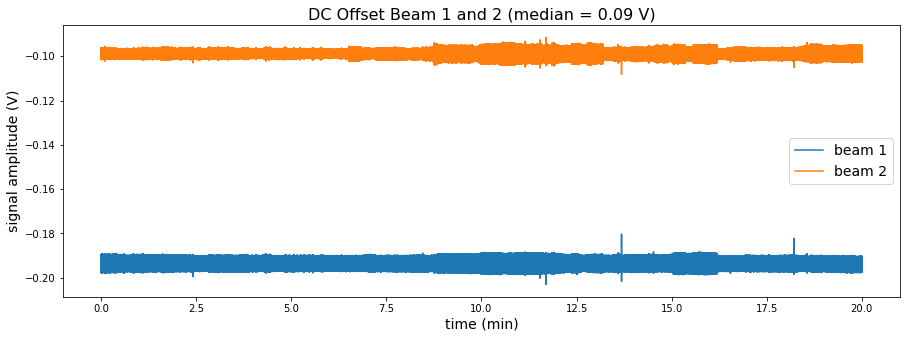

In [10]:
def __get_timeline(tr):
    dt = tr.stats.delta
    return np.arange(0, tr.data.size*dt, dt)

timeline = __get_timeline(f1[0])

med = np.median(abs(f1[0].data-f2[0].data))


def __makeplot_DCoffset():

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 14

    ax.plot(timeline/60, f1[0].data, label="beam 1")
    ax.plot(timeline/60, f2[0].data, label="beam 2")

    ax.set_ylabel("signal amplitude (V)", fontsize=font)

    ax.set_xlabel("time (min)", fontsize=font)

    ax.set_title(f"DC Offset Beam 1 and 2 (median = {round(med,2)} V)", fontsize=font+2)

    ax.legend(fontsize=font)

    plt.show(); 
    return fig

__makeplot_DCoffset();

In [11]:
# fig.savefig(
#             path2plots+"plot_dc_offset.png", 
#             dpi=300, facecolor='w', 
#             edgecolor='w',
#             orientation='portrait', 
#             format="png",
#             transparent=False, 
#             bbox_inches="tight", 
#             pad_inches=0.2,
#            )

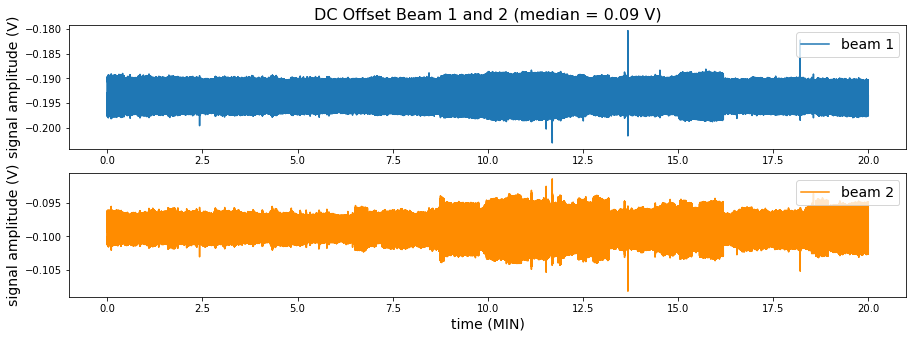

FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/Documents/ROMY/monobeams/West_Ring/plot_ulrich1.png'

In [12]:

def __makeplot_ulrich1():

    fig, ax = plt.subplots(2, 1, figsize=(15, 5))

    font = 14

    ax[0].plot(timeline/60, f1[0].data, label="beam 1")
    ax[1].plot(timeline/60, f2[0].data, label="beam 2", color='darkorange')

    ax[0].set_ylabel("signal amplitude (V)", fontsize=font)
    ax[1].set_ylabel("signal amplitude (V)", fontsize=font)

    ax[1].set_xlabel("time (MIN)", fontsize=font)

    ax[0].set_title(f"DC Offset Beam 1 and 2 (median = {round(med,2)} V)", fontsize=font+2)

    ax[0].legend(loc="upper right", fontsize=font)
    ax[1].legend(loc="upper right", fontsize=font)

    plt.show(); 
    return fig


fig = __makeplot_ulrich1();

fig.savefig(path2plots+"plot_ulrich1.png", 
            dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format="png",
            transparent=False, bbox_inches="tight", pad_inches=0.2,
           )

n1, n2 = 0, 500

def __makeplot_ulrich2():

    fig, ax = plt.subplots(2, 1, figsize=(15, 5))

    font = 14

    ax[0].plot(timeline[n1:n2], f1[0].data[n1:n2]-np.median(f1[0].data[n1:n2]), label="beam 1")
    ax[1].plot(timeline[n1:n2], f2[0].data[n1:n2]-np.median(f2[0].data[n1:n2]), label="beam 2", color='darkorange')

    ax[0].set_ylabel("signal amplitude (V)", fontsize=font)
    ax[1].set_ylabel("signal amplitude (V)", fontsize=font)

    ax[1].set_xlabel("time (s)", fontsize=font)

    ax[0].set_title(f"DC Offset Beam 1 and 2 (median = {round(med,2)} V)", fontsize=font+2)

    ax[0].axhline(0, ls='--', color='k', zorder=0, alpha=0.4)
    ax[1].axhline(0, ls='--', color='k', zorder=0, alpha=0.4)

    ax[0].legend(fontsize=font)
    ax[1].legend(fontsize=font)

    plt.show(); 
    return fig


fig = __makeplot_ulrich2();

fig.savefig(path2plots+"plot_ulrich2.png", 
            dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format="png",
            transparent=False, bbox_inches="tight", pad_inches=0.2,
           )

## Envelope

In [ ]:

## envelopes
f1_env = np.abs(hilbert(f1[0].data))
f2_env = np.abs(hilbert(f2[0].data))

diff_f1_f2 = abs(f1_env - f2_env)
diff_perc =  diff_f1_f2 / max(diff_f1_f2) * 100


## spectra
# f1_env_ads, f1_env_f = __fft(f1_env, f1[0].stats.delta, window=None)    
# f2_env_ads, f2_env_f = __fft(f2_env, f2[0].stats.delta, window=None)    


## normalizing
f1_env /= max(f1_env)
f2_env /= max(f2_env)


In [ ]:
from numpy import median

Nsamples = 5000 * 1
sample_offset = 5000 * 60 * 7

dt = f1[0].stats.delta
f1_env_t = np.arange(0, f1_env.size*dt, dt)


## ______________________________________________________________

def __makeplot_envelope_comparison():
    
    fig, ax = plt.subplots(3, 1, figsize=(15,10), sharex=True)

    font=15

    num1 = sample_offset
    num2 = num1 + Nsamples
    
    f1_env_set =  f1_env[num1:num2] / max(f1_env[num1:num2])
    f2_env_set =  f2_env[num1:num2] / max(f2_env[num1:num2])

    diff = abs(f1_env_set - f2_env_set) / f2_env_set * 100
    

    ax[0].plot(f1_env_t[num1:num2], f1_env_set, label='beam f1', color="darkblue")

    ax[0].plot(f1_env_t[num1:num2], f2_env_set, label='beam f2', color="darkorange")

    ax[1].plot(f1_env_t[num1:num2], diff, color="k", label=' |beam f1 - beam f2| / beam f2 ')

    ax[2].plot(f1_env_t[num1:num2], abs(f1_env_set - f2_env_set), color="k", label=' beam f1 - beam f2')   
    
    
    ax[2].set_xlabel("Time (s)", fontsize=font)
    
    for i in range(3):
        ax[i].legend(fontsize=font-1, loc="upper right")

        ax[i].grid(ls='--', zorder=0)
 

    ax[0].set_ylabel("norm. signal amplitude", fontsize=font)
    ax[1].set_ylabel("difference (%)", fontsize=font)
    ax[2].set_ylabel("abs. difference (V)", fontsize=font)

    plt.plot();
    
    return fig

fig = __makeplot_envelope_comparison();


# fig.savefig(path2plots+"plot_norm_monobeams_and_differences.png", 
#             dpi=300, facecolor='w', edgecolor='w',
#             orientation='portrait', format="png",
#             transparent=False, bbox_inches="tight", pad_inches=0.2,
#            )

In [ ]:

print(min(diff_f1_f2), max(diff_f1_f2))
print(min(diff_perc), max(diff_perc))


data = diff_perc

lnspc = np.linspace(min(data), max(data), len(data))

ae, loce, scalee = stats.skewnorm.fit(data, loc=50, scale=15)

p = stats.skewnorm.pdf(lnspc, ae, loce, scalee)

plt.plot(lnspc, p, 'k', linewidth=2)

plt.hist(data,
         bins=200,
         range=(0,100),
         rwidth=1.0,
         density=True,
        );

In [ ]:
import pandas as pd
df = pd.DataFrame(data, columns=["data"])
# df.hist(bins=200)

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(df.data, kde=False, fit=stats.skewnorm)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(f1[0].data/max(f1[0].data))
plt.plot(f2[0].data/max(abs(f2[0].data)))
plt.plot(abs(f1[0].data/max(f1[0].data) - f2[0].data/max(f2[0].data)))
plt.xlim(1000, 2000)